In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [2]:

data_dir = os.path.abspath(os.path.join('..', 'data', 'processed')) if not os.path.exists('data/processed') else 'data/processed'

X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (113, 128, 561)
y_train shape: (113,)
X_test shape: (45, 128, 561)
y_test shape: (45,)


In [3]:
def create_model(input_shape, num_classes):
    """Create a CNN-LSTM model"""
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        LSTM(100, return_sequences=True),
        Dropout(0.25),
        LSTM(50),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))
model = create_model(input_shape, num_classes)
model.summary()

C:\Users\AHMED HAMED\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │       107,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 100)        │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,869 (1007.30 KB)

 Trainable params: 257,869 (1007.30 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    os.path.join(output_dir, 'best_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
tensorboard = TensorBoard(
    log_dir=os.path.join(output_dir, 'logs'),
    histogram_freq=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[checkpoint, early_stopping, tensorboard]
)

Epoch 1/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1528 - loss: 1.6027  
Epoch 1: val_accuracy improved from -inf to 0.37778, saving model to output\best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.2049 - loss: 1.5738 - val_accuracy: 0.3778 - val_loss: 1.4586
Epoch 2/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4549 - loss: 1.3729
Epoch 2: val_accuracy improved from 0.37778 to 0.40000, saving model to output\best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4428 - loss: 1.3788 - val_accuracy: 0.4000 - val_loss: 1.3812
Epoch 3/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5417 - loss: 1.2917
Epoch 3: val_accuracy improved from 0.40000 to 0.44444, saving model to output\best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5303 - loss: 1.2990 - val_accuracy: 0.4444 - val_loss: 1.3340
Epoch 4/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5521 - loss: 1.2412
Epoch 4: val_accuracy improved from 0.44444 to 0.48889, saving model to output\best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5613 - loss: 1.2457 - val_accuracy: 0.4889 - val_loss: 1.3175
Epoch 5/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5642 - loss: 1.2447
Epoch 5: val_accuracy did not improve from 0.48889
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5616 - loss: 1.2335 - val_accuracy: 0.4889 - val_loss: 1.3222
Epoch 6/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6389 - loss: 1.1114
Epoch 6: val_accuracy did not improve from 0.48889
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6170 - loss: 1.1394 - val_accuracy: 0.4667 - val_loss: 1.3259
Epoch 7/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5903 - loss: 1.1154
Epoch 7: val_accuracy did not improve from 0.48889
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5736 - loss: 1.1366 - val_accuracy: 0.4667 - val_loss: 1.3151
Epoch 8/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5799 - loss: 1.1657
Epoch 8: val_accuracy did not improve from 0.48889
4/4 

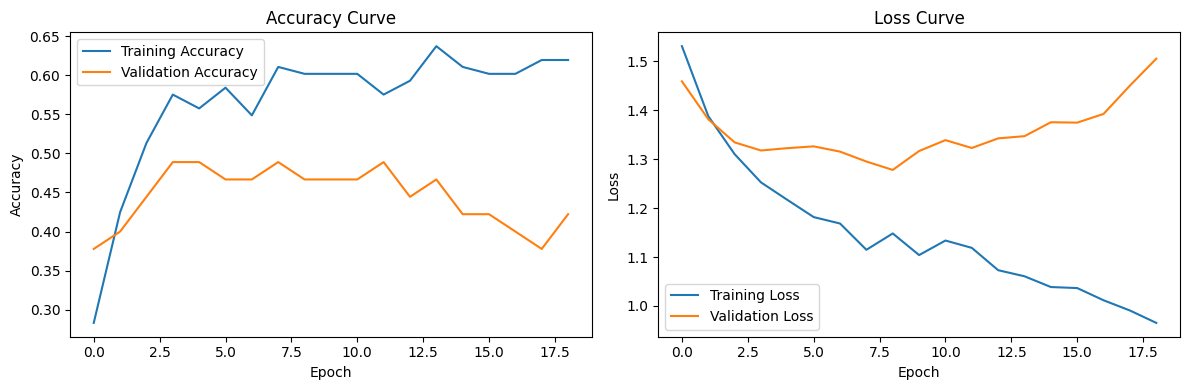

In [5]:
def plot_training_history(history, output_dir):
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'training_history.png'))
    plt.show()

plot_training_history(history, output_dir)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4465 - loss: 1.2936

Test accuracy: 0.4667
Test loss: 1.2778
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.47      0.75      0.58        12
           4       0.53      0.64      0.58        14

    accuracy                           0.47        45
   macro avg       0.29      0.33      0.30        45
weighted avg       0.40      0.47      0.42        45



C:\Users\AHMED HAMED\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AHMED HAMED\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AHMED HAMED\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\met

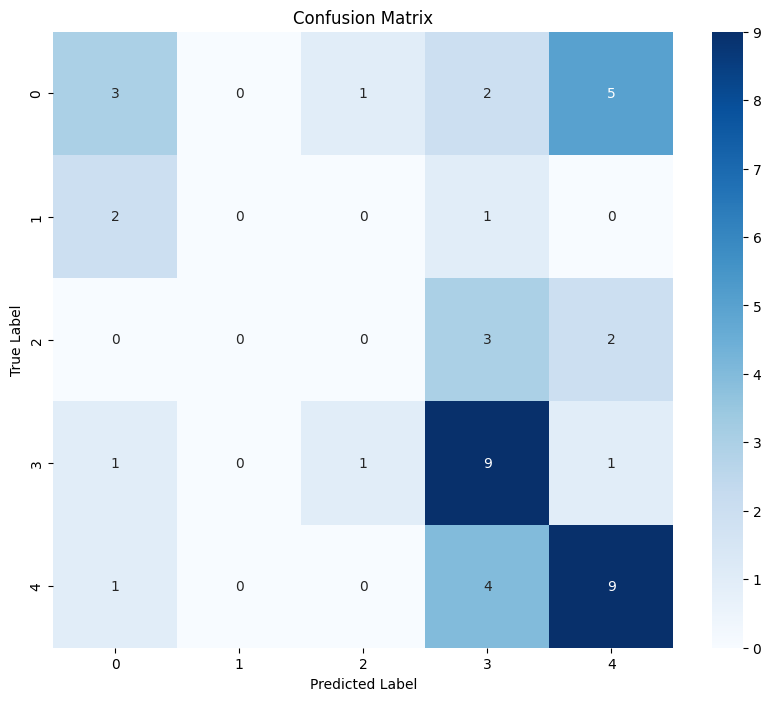

In [6]:
def plot_confusion_matrix(y_true, y_pred, output_dir):
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(plots_dir, 'confusion_matrix.png'))
    plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

plot_confusion_matrix(y_test, y_pred_classes, output_dir)

In [8]:
def predict_activity(model, data):
    """
    Predict activity from input data and return the activity name and probabilities
    
    Args:
        model: Trained CNN-LSTM model
        data: Input data of shape (1, 128, 561)
    
    Returns:
        predicted_activity: Name of the predicted activity
        probabilities: Dictionary of activity names and their probabilities
    """
    # Activity names in English
    activity_names = {
        0: 'Walking',
        1: 'Walking Upstairs',
        2: 'Walking Downstairs',
        3: 'Sitting',
        4: 'Standing'
    }
    
    # Get predictions
    predictions = model.predict(data)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_activity = activity_names[predicted_class]
    
    # Get probabilities for each activity
    probabilities = {
        activity_names[i]: float(predictions[0][i])
        for i in range(len(activity_names))
    }
    
    # Print results
    print(f"\nPredicted Activity: {predicted_activity}")
    print("\nProbabilities for each activity:")
    for activity, prob in probabilities.items():
        print(f"{activity}: {prob:.4f}")
    
    return predicted_activity, probabilities

# Example usage:
# sample_data = X_test[0:1]  # Take first test sample
# predicted_activity, probabilities = predict_activity(model, sample_data)

In [9]:
# اختبار التنبؤ على عينة من بيانات الاختبار
sample_data = X_test[0:1]  # أخذ أول عينة من بيانات الاختبار
predicted_activity, probabilities = predict_activity(model, sample_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Predicted Activity: Standing

Probabilities for each activity:
Walking: 0.2072
Walking Upstairs: 0.0279
Walking Downstairs: 0.1357
Sitting: 0.0588
Standing: 0.5703
